### Deep Reinforcement Learning-based Image Captioning with Embedding Reward
Pranshu Gupta, Deep Learning @ Georgia Institute of Technology

In [137]:
# As usual, a bit of setup
from __future__ import print_function
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import nltk

import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.nn import functional as F

from cs231n.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from cs231n.image_utils import image_from_url

from torchsummary import summary

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Working on: ", device)

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

max_seq_len = 17

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Working on:  cuda:0


### Load MS-COCO data
We will use the Microsoft COCO dataset for captioning.

In [50]:
# Load COCO data from disk; this returns a dictionary
# We'll work with dimensionality-reduced features for this notebook, but feel
# free to experiment with the original features by changing the flag below.
data = load_coco_data(pca_features=True)

data["train_captions_lens"] = np.zeros(data["train_captions"].shape[0])
data["val_captions_lens"] = np.zeros(data["val_captions"].shape[0])
for i in range(data["train_captions"].shape[0]):
    data["train_captions_lens"][i] = np.nonzero(data["train_captions"][i] == 2)[0][0] + 1
for i in range(data["val_captions"].shape[0]):
    data["val_captions_lens"][i] = np.nonzero(data["val_captions"][i] == 2)[0][0] + 1


# Print out all the keys and values from the data dictionary
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63
train_captions_lens <class 'numpy.ndarray'> (400135,) float64
val_captions_lens <class 'numpy.ndarray'> (195954,) float64


### Caption Evaluation

In [51]:
def BLEU_score(gt_caption, sample_caption):
    """
    gt_caption: string, ground-truth caption
    sample_caption: string, your model's predicted caption
    Returns unigram BLEU score.
    """
    reference = [x for x in gt_caption.split(' ') 
                 if ('<END>' not in x and '<START>' not in x and '<UNK>' not in x)]
    hypothesis = [x for x in sample_caption.split(' ') 
                  if ('<END>' not in x and '<START>' not in x and '<UNK>' not in x)]
    BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis, weights = [1])
    return BLEUscore

def evaluate_model(model):
    """
    model: CaptioningRNN model
    Prints unigram BLEU score averaged over 1000 training and val examples.
    """
    BLEUscores = {}
    for split in ['train', 'val']:
        minibatch = sample_coco_minibatch(data, split=split, batch_size=1000)
        gt_captions, features, urls = minibatch
        gt_captions = decode_captions(gt_captions, data['idx_to_word'])

        sample_captions = model.sample(features)
        sample_captions = decode_captions(sample_captions, data['idx_to_word'])

        total_score = 0.0
        for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
            total_score += BLEU_score(gt_caption, sample_caption)

        BLEUscores[split] = total_score / len(sample_captions)

    for split in BLEUscores:
        print('Average BLEU score for %s: %f' % (split, BLEUscores[split]))

### Policy Network

In [52]:
class PolicyNetwork(nn.Module):
    def __init__(self, word_to_idx, input_dim=512, wordvec_dim=512, hidden_dim=512, dtype=np.float32):
        super(PolicyNetwork, self).__init__()
        
        self.word_to_idx = word_to_idx
        self.idx_to_word = {i: w for w, i in word_to_idx.items()}
        
        vocab_size = len(word_to_idx)
        
        self.caption_embedding = nn.Embedding(vocab_size, wordvec_dim)
        
        self.cnn2linear = nn.Linear(input_dim, hidden_dim)
        self.lstm = nn.LSTM(wordvec_dim, hidden_dim, batch_first=True)
        self.linear2vocab = nn.Linear(hidden_dim, vocab_size)
        self.probs = nn.Softmax(dim=1)
        
    def forward(self, features, captions):
        input_captions = self.caption_embedding(captions)
        hidden_init = self.cnn2linear(features)
        cell_init = torch.zeros_like(hidden_init)
        output, _ = self.lstm(input_captions, (hidden_init, cell_init))
        output = self.linear2vocab(output)
        return output

### Training the Policy Network

In [53]:
policyNetwork = PolicyNetwork(data["word_to_idx"]).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(policyNetwork.parameters(), lr=0.0001)

In [54]:
small_data = load_coco_data(max_train=50000)

In [57]:
batch_size = 50
bestLoss = 10000
bestModel = None

for epoch in range(50000):
    captions, features, _ = sample_coco_minibatch(small_data, batch_size=batch_size, split='train')
    features = torch.tensor(features, device=device).float().unsqueeze(0)
    captions_in = torch.tensor(captions[:, :-1], device=device).long()
    captions_ou = torch.tensor(captions[:, 1:], device=device).long()
    output = policyNetwork(features, captions_in)
    
    loss = 0
    for i in range(batch_size):
        caplen = np.nonzero(captions[i] == 2)[0][0] + 1
        loss += (caplen/batch_size)*criterion(output[i][:caplen], captions_ou[i][:caplen])
    
    if loss.item() < bestLoss:
        bestLoss = loss.item()
        bestModel = policyNetwork
        print("epoch:", epoch, "loss:", loss.item())
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

torch.save(bestModel.state_dict(), "policyNetwork.pt")

epoch: 0 loss: 10.344365119934082
epoch: 3 loss: 10.179471969604492
epoch: 17 loss: 10.02580451965332
epoch: 32 loss: 9.871771812438965
epoch: 47 loss: 9.743988990783691
epoch: 49 loss: 8.812932968139648
epoch: 291 loss: 8.67715072631836
epoch: 336 loss: 8.276082038879395
epoch: 376 loss: 8.249432563781738
epoch: 399 loss: 8.062466621398926
epoch: 502 loss: 8.006856918334961
epoch: 527 loss: 7.8093061447143555
epoch: 608 loss: 7.712879180908203
epoch: 676 loss: 7.533693790435791
epoch: 762 loss: 7.414658546447754
epoch: 774 loss: 7.262825965881348
epoch: 782 loss: 7.2376885414123535
epoch: 907 loss: 7.1637959480285645
epoch: 911 loss: 7.10874605178833
epoch: 938 loss: 6.934282302856445
epoch: 980 loss: 6.9209394454956055
epoch: 1005 loss: 6.589231491088867
epoch: 1107 loss: 6.376235485076904
epoch: 1117 loss: 6.227982044219971
epoch: 1248 loss: 6.101768493652344
epoch: 1262 loss: 5.96243143081665
epoch: 1309 loss: 5.938260078430176
epoch: 1428 loss: 5.467482089996338
epoch: 1652 loss: 

epoch: 22905 loss: 0.029251957312226295
epoch: 23273 loss: 0.02822219766676426
epoch: 23323 loss: 0.027365315705537796
epoch: 23413 loss: 0.02725229226052761
epoch: 23515 loss: 0.026646923273801804
epoch: 23694 loss: 0.025608716532588005
epoch: 23754 loss: 0.024744512513279915
epoch: 23820 loss: 0.023553505539894104
epoch: 24102 loss: 0.023297669366002083
epoch: 24267 loss: 0.023097923025488853
epoch: 24341 loss: 0.022959310561418533
epoch: 24415 loss: 0.02175622060894966
epoch: 24599 loss: 0.020215949043631554
epoch: 27552 loss: 0.01901116780936718
epoch: 28024 loss: 0.01788322627544403
epoch: 28083 loss: 0.01761564053595066
epoch: 28290 loss: 0.017190484330058098
epoch: 28305 loss: 0.01714828424155712
epoch: 28412 loss: 0.015786800533533096
epoch: 31763 loss: 0.015440654009580612
epoch: 31922 loss: 0.014904175885021687
epoch: 32094 loss: 0.014722405932843685
epoch: 32207 loss: 0.01450385246425867
epoch: 34512 loss: 0.014189643785357475
epoch: 34744 loss: 0.014027117751538754
epoch: 3

### Testing the Policy Network

In [117]:
policyNet = PolicyNetwork(data["word_to_idx"]).to(device)
policyNet.load_state_dict(torch.load('models/policyNetwork.pt'))
policyNet.train(mode=False)

PolicyNetwork(
  (caption_embedding): Embedding(1004, 512)
  (cnn2linear): Linear(in_features=512, out_features=512, bias=True)
  (lstm): LSTM(512, 512, batch_first=True)
  (linear2vocab): Linear(in_features=512, out_features=1004, bias=True)
  (probs): Softmax(dim=1)
)

In [188]:
max_seq_len = 17
captions, features, urls = sample_coco_minibatch(small_data, batch_size=10, split='val')
features = torch.tensor(features, device=device).float().unsqueeze(0)
gen_caps = torch.tensor(captions[:, 0:1], device=device).long()
for t in range(max_seq_len-1):
    output = policyNet(features, gen_caps)
    gen_caps = torch.cat((gen_caps, output[:, -1:, :].argmax(axis=2)), axis=1)

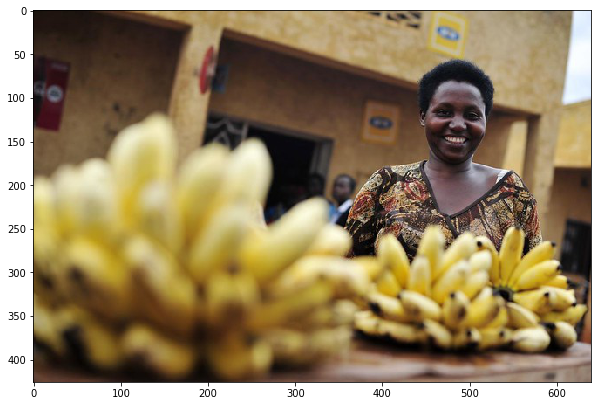

GEN: <START> a wooden table topped with a <UNK> and <UNK> <END>
TRU: <START> a black woman standing over a <UNK> of yellow bananas <END>


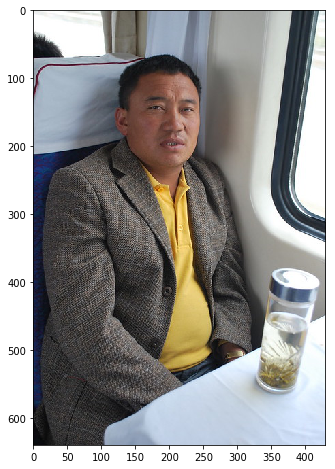

GEN: <START> a man wearing a <UNK> hat on a surfboard <END>
TRU: <START> a man is sitting at a table on a train <END>
URL Error:  Gone http://farm8.staticflickr.com/7048/7005967367_eaf1c8bda8_z.jpg
URL Error:  Not Found http://farm8.staticflickr.com/7441/10213868386_a8820fc902_z.jpg


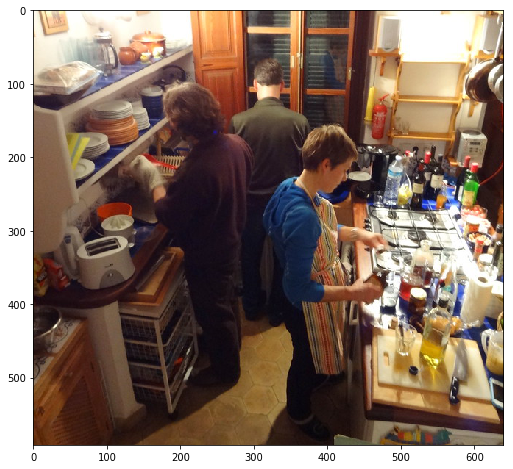

GEN: <START> a group of people standing around in front of a <UNK> cake <END>
TRU: <START> three people are preparing a meal in a small kitchen <END>


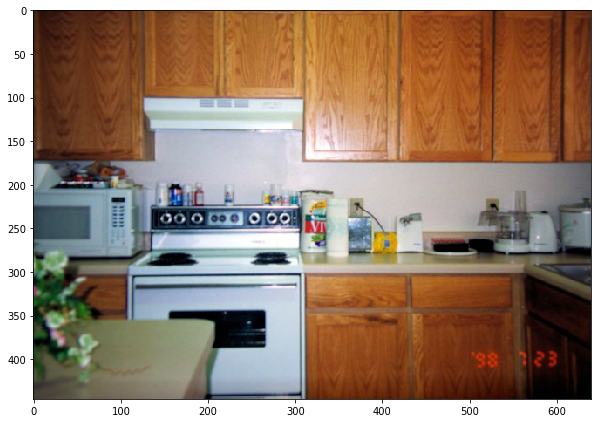

GEN: <START> a white kitchen with a microwave oven and sink <END>
TRU: <START> a kitchen with a stove a sink and a microwave <END>


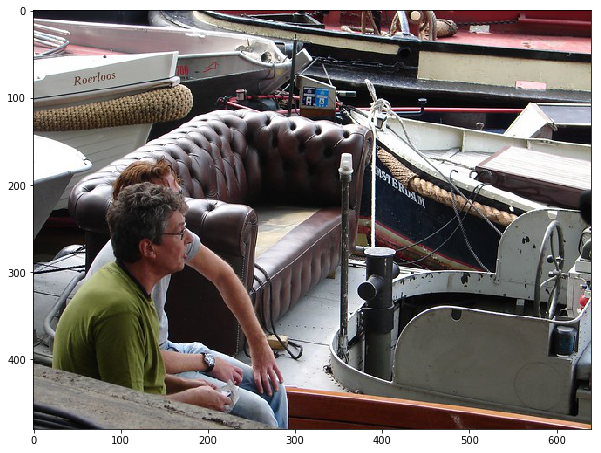

GEN: <START> the woman is sitting on the ground with her dog <END>
TRU: <START> people sitting near boats and a leather sofa <END>


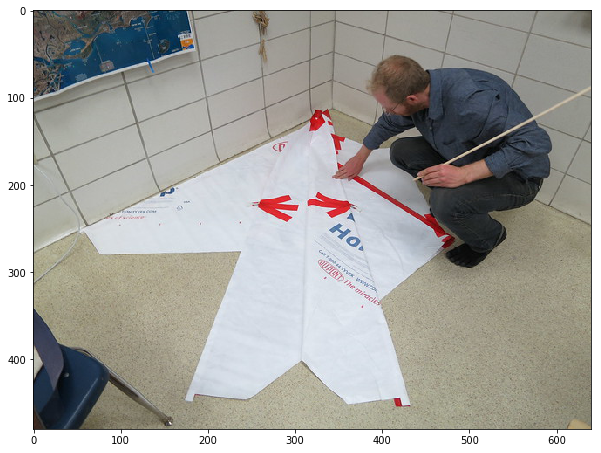

GEN: <START> a cat looking at his <UNK> computer with a <UNK> phone <END>
TRU: <START> a man inside a room putting together a white kite <END>


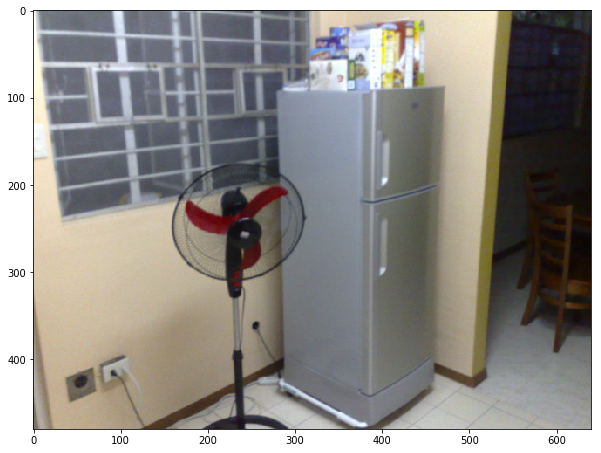

GEN: <START> a cat is on a chair in a kitchen <END>
TRU: <START> the <UNK> is <UNK> into the wall next to a refrigerator <END>


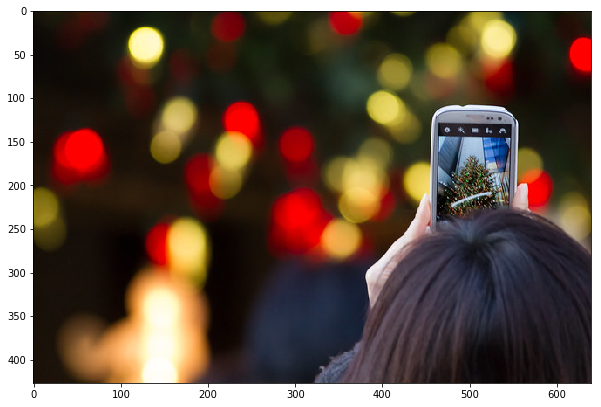

GEN: <START> a person holding up <UNK> outside with them <UNK> <END>
TRU: <START> a girl taking pictures of christmas lights with her phone <END>


In [190]:
decoded_gen_caps = decode_captions(gen_caps, data["idx_to_word"])
decoded_tru_caps = decode_captions(captions, data["idx_to_word"])
for i in range(10):
    try:
        plt.imshow(image_from_url(urls[i]))
    except:
        continue
    plt.show()
    print("GEN:", decoded_gen_caps[i])
    print("TRU:", decoded_tru_caps[i])

### Reward Network

In [64]:
class RewardNetworkRNN(nn.Module):
    def __init__(self, word_to_idx, input_dim=512, wordvec_dim=512, hidden_dim=512, dtype=np.float32):
        super(RewardNetworkRNN, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.word_to_idx = word_to_idx
        self.idx_to_word = {i: w for w, i in word_to_idx.items()}
        vocab_size = len(word_to_idx)
        
        self.hidden_cell = torch.zeros(1, 1, self.hidden_dim).to(device)
        
        self.caption_embedding = nn.Embedding(vocab_size, wordvec_dim)
        self.gru = nn.GRU(wordvec_dim, hidden_dim)
    
    def forward(self, captions):
        input_captions = self.caption_embedding(captions)
        output, self.hidden_cell = self.gru(input_captions.view(len(input_captions) ,1, -1), self.hidden_cell)
        return output
    
class RewardNetwork(nn.Module):
    def __init__(self, word_to_idx):
        super(RewardNetwork, self).__init__()
        self.rewrnn = RewardNetworkRNN(word_to_idx)
        self.visual_embed = nn.Linear(512, 512)
        self.semantic_embed = nn.Linear(512, 512)
        
    def forward(self, features, captions):
        for t in range(captions.shape[1]):
            rrnn = self.rewrnn(captions[:, t])
        rrnn = rrnn.squeeze(0).squeeze(1)
        se = self.semantic_embed(rrnn)
        ve = self.visual_embed(features)
        return ve, se

In [66]:
rewardNetwork = RewardNetwork(data["word_to_idx"]).to(device)
optimizer = optim.Adam(rewardNetwork.parameters(), lr=0.001)

# https://cs230-stanford.github.io/pytorch-nlp.html#writing-a-custom-loss-function
def VisualSemanticEmbeddingLoss(visuals, semantics):
    beta = 0.002
    N, D = visuals.shape
    
    visloss = torch.mm(visuals, semantics.t())
    visloss = visloss - torch.diag(visloss).unsqueeze(1)
    visloss = visloss + (beta/N)*(torch.ones((N, N)).to(device) - torch.eye(N).to(device))
    visloss = F.relu(visloss)
    visloss = torch.sum(visloss)/N
    
    semloss = torch.mm(semantics, visuals.t())
    semloss = semloss - torch.diag(semloss).unsqueeze(1)
    semloss = semloss + (beta/N)*(torch.ones((N, N)).to(device) - torch.eye(N).to(device))
    semloss = F.relu(semloss)
    semloss = torch.sum(semloss)/N
    
    return visloss + semloss        

In [67]:
small_data = load_coco_data(max_train=50000)

In [69]:
batch_size = 50
bestLoss = 10000
bestModel = None

for epoch in range(50000):
    captions, features, _ = sample_coco_minibatch(small_data, batch_size=batch_size, split='train')
    features = torch.tensor(features, device=device).float()
    captions = torch.tensor(captions, device=device).long()
    ve, se = rewardNetwork(features, captions)
    loss = VisualSemanticEmbeddingLoss(ve, se)
    
    if loss.item() < bestLoss:
        bestLoss = loss.item()
        bestModel = rewardNetwork
        print("epoch:", epoch, "loss:", loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    rewardNetwork.rewrnn.hidden_cell.detach_()
    
torch.save(bestModel.state_dict(), "rewardNetwork.pt")

epoch: 0 loss: 153.8406219482422
epoch: 1 loss: 145.78004455566406
epoch: 2 loss: 144.26637268066406
epoch: 5 loss: 127.2883529663086
epoch: 17 loss: 126.70248413085938
epoch: 21 loss: 122.92036437988281
epoch: 45 loss: 117.26567077636719
epoch: 48 loss: 109.99120330810547
epoch: 56 loss: 105.07620239257812
epoch: 183 loss: 104.64308166503906
epoch: 198 loss: 96.82013702392578
epoch: 209 loss: 94.6942138671875
epoch: 275 loss: 93.03327178955078
epoch: 286 loss: 86.01957702636719
epoch: 345 loss: 83.19971466064453
epoch: 402 loss: 82.8239974975586
epoch: 447 loss: 80.05474853515625
epoch: 450 loss: 66.36756134033203
epoch: 589 loss: 53.008888244628906
epoch: 825 loss: 52.94926452636719
epoch: 964 loss: 52.840293884277344
epoch: 965 loss: 52.49498748779297
epoch: 974 loss: 51.35733413696289
epoch: 983 loss: 49.916099548339844
epoch: 984 loss: 48.341064453125
epoch: 1031 loss: 46.65217590332031
epoch: 1099 loss: 44.16111373901367
epoch: 1141 loss: 41.64582061767578
epoch: 1358 loss: 39.97

### Value Network

In [111]:
class ValueNetworkRNN(nn.Module):
    def __init__(self, word_to_idx, input_dim=512, wordvec_dim=512, hidden_dim=512, dtype=np.float32):
        super(ValueNetworkRNN, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.word_to_idx = word_to_idx
        self.idx_to_word = {i: w for w, i in word_to_idx.items()}
        vocab_size = len(word_to_idx)
        
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_dim).to(device), torch.zeros(1, 1, self.hidden_dim).to(device))
        
        self.caption_embedding = nn.Embedding(vocab_size, wordvec_dim)
        self.lstm = nn.LSTM(wordvec_dim, hidden_dim)
        
    def forward(self, captions):
        input_captions = self.caption_embedding(captions)
        output, self.hidden_cell = self.lstm(input_captions.view(len(input_captions) ,1, -1), self.hidden_cell)
        return output
    
class ValueNetwork(nn.Module):
    def __init__(self, word_to_idx):
        super(ValueNetwork, self).__init__()
        self.valrnn = ValueNetworkRNN(word_to_idx)
        self.linear1 = nn.Linear(1024, 512)
        self.linear2 = nn.Linear(512, 1)
    
    def forward(self, features, captions):
        for t in range(captions.shape[1]):
            vrnn = self.valrnn(captions[:, t])
        vrnn = vrnn.squeeze(0).squeeze(1)
        state = torch.cat((features, vrnn), dim=1)
        output = self.linear1(state)
        output = self.linear2(output)
        return output

In [115]:
valueNetwork = ValueNetwork(data["word_to_idx"]).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(valueNetwork.parameters(), lr=0.0001)

rewardNet = RewardNetwork(data["word_to_idx"]).to(device)
rewardNet.load_state_dict(torch.load('models/rewardNetwork.pt'))
rewardNet.train(mode=False)

policyNet = PolicyNetwork(data["word_to_idx"]).to(device)
policyNet.load_state_dict(torch.load('models/policyNetwork.pt'))
policyNet.train(mode=False)

PolicyNetwork(
  (caption_embedding): Embedding(1004, 512)
  (cnn2linear): Linear(in_features=512, out_features=512, bias=True)
  (lstm): LSTM(512, 512, batch_first=True)
  (linear2vocab): Linear(in_features=512, out_features=1004, bias=True)
  (probs): Softmax(dim=1)
)

In [116]:
small_data = load_coco_data(max_train=50000)

In [114]:
batch_size = 50
bestLoss = 10000
bestModel = None
max_seq_len = 17

for epoch in range(50000):
    _, features, _ = sample_coco_minibatch(small_data, batch_size=batch_size, split='train')
    features = torch.tensor(features, device=device).float()
    
    # Generate captions using the policy network
    for t in range(max_seq_len):
        
    
    # Compute the reward of the generated caption using reward network
    
    
    # Compute the value of a random state in the generation process
    values = valueNetwork(features, captions)
    
    # Compute the loss for the value and the reward
    loss = criterion(values, rewards)
    
    if loss.item() < bestLoss:
        bestLoss = loss.item()
        bestModel = rewardNetwork
        print("epoch:", epoch, "loss:", loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    valueNetwork.valrnn.hidden_cell[0].detach_()
    valueNetwork.valrnn.hidden_cell[1].detach_()

torch.save(bestModel.state_dict(), "valueNetwork.pt")

epoch: 0 loss: 1.2250399589538574
epoch: 1 loss: 0.9250077605247498
epoch: 2 loss: 0.7536917328834534
epoch: 3 loss: 0.3861948251724243
epoch: 4 loss: 0.3757738173007965
epoch: 5 loss: 0.27767589688301086
epoch: 10 loss: 0.26993873715400696
epoch: 12 loss: 0.23411642014980316
epoch: 13 loss: 0.18429531157016754
epoch: 14 loss: 0.15986301004886627
epoch: 17 loss: 0.15536648035049438
epoch: 20 loss: 0.1531573235988617
epoch: 21 loss: 0.09698668122291565
epoch: 27 loss: 0.07783440500497818
epoch: 30 loss: 0.07036525756120682
epoch: 31 loss: 0.06466038525104523
epoch: 36 loss: 0.0612495094537735
epoch: 38 loss: 0.049606822431087494
epoch: 39 loss: 0.041790228337049484
epoch: 40 loss: 0.03289847448468208
epoch: 53 loss: 0.028289081528782845
epoch: 54 loss: 0.020854895934462547
epoch: 59 loss: 0.0195535346865654
epoch: 61 loss: 0.011129345744848251
epoch: 78 loss: 0.009699464775621891
epoch: 82 loss: 0.009290221147239208
epoch: 83 loss: 0.007927309721708298
epoch: 84 loss: 0.0060142553411424

KeyboardInterrupt: 

## Reinforcement Learning